In [44]:
import sys
sys.path.append("../")

import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from tqdm import *
import torch
from torch import nn

from utils.utils import ring2nest
from utils import create_mask as cm

from models.embedding import SphericalGraphCNN
from models.scd import dnds
from utils.psf_correction import PSFCorrection
from models.psf import KingPSF
from simulations.wrapper import simulator
from utils.templates import get_NFW2_template
from sbi import utils
from sbi import inference
from sbi.inference import PosteriorEstimator
from sbi import utils
from sbi import inference
from utils.plotting import make_plot, make_signal_injection_plot

%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [ ]:
import matplotlib.pylab as pylab
import warnings
import matplotlib.cbook

from plot_params import params

warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

pylab.rcParams.update(params)
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Test of PS mismodeling

## Preliminaries

In [47]:
nside_list = [128, 64, 32, 16, 8, 4, 2]

In [48]:
hp_mask_nside1 = cm.make_mask_total(nside=1, band_mask = True, band_mask_range = 0,
                              mask_ring = True, inner = 0, outer = 25)

indexes_list = []
masks_list = []
for nside in nside_list:
    hp_mask = hp.reorder(hp.ud_grade(hp_mask_nside1, nside), r2n=True)
    masks_list.append(hp_mask)
    indexes_list.append(np.arange(hp.nside2npix(nside))[~hp_mask])

hp_mask_nside1 = hp.reorder(hp_mask_nside1, r2n=True)

In [49]:
hp_mask_nside1_ring = cm.make_mask_total(nside=1, band_mask = True, band_mask_range = 0, mask_ring = True, inner = 0, outer = 25)
roi_sim_ring = hp.ud_grade(hp_mask_nside1_ring, 128)

In [50]:
ps_mask = np.load("../data/mask_3fgl_0p8deg.npy")
hp_mask = cm.make_mask_total(nside=128, band_mask = True, band_mask_range = 2,
                              mask_ring = True, inner = 0, outer = 25, custom_mask=ps_mask)
hp_mask = hp.reorder(hp_mask, r2n=True)
hp_mask

array([ True,  True,  True, ...,  True,  True,  True])

In [53]:
kp = KingPSF()

pc_inst = PSFCorrection(delay_compute=True)
pc_inst.psf_r_func = lambda r: kp.psf_fermi_r(r)

In [57]:
# Load templates
temp_gce = np.load("../data/fermi_data/template_gce.npy")

fermi_exp = np.load("../data/fermi_data/fermidata_exposure.npy")

# Rescaling factor to remove exposure from PS templates
rescale = fermi_exp / np.mean(fermi_exp)

roi_normalize_temps = cm.make_mask_total(nside=128, band_mask = True, band_mask_range=2, mask_ring=True, inner=0, outer=30)
temp_gce = get_NFW2_template(gamma=1.2, exp_map=fermi_exp, roi_normalize=roi_normalize_temps)

temp_dif = np.load("../data/fermi_data/template_dif.npy")
temp_psc = np.load("../data/fermi_data/template_psc.npy")
temp_iso = np.load("../data/fermi_data/template_iso.npy")
temp_dsk_thk = np.load("../data/fermi_data/template_dsk.npy")
temp_dsk = np.load("../data/external/template_disk_r_s_5_z_s_0.3.npy")
temp_bub = np.load("../data/fermi_data/template_bub.npy")

temp_mO_pibrem = np.load('../data/fermi_data/ModelO_r25_q1_pibrem.npy')
temp_mO_ics = np.load('../data/fermi_data/ModelO_r25_q1_ics.npy')

temp_mA_pibrem = hp.ud_grade(np.load('../data/modelA/modelA_brempi0.npy'), nside_out=128, power=-2)
temp_mA_ics = hp.ud_grade(np.load('../data/modelA/modelA_ics.npy'), nside_out=128, power=-2)

temp_mA_pibrem /= np.mean(temp_mA_pibrem[~roi_normalize_temps] )
temp_mA_ics /= np.mean(temp_mA_ics[~roi_normalize_temps] )


ps_mask = np.load("../data/mask_3fgl_0p8deg.npy")

roi_mask = hp.reorder(cm.make_mask_total(nside=128, band_mask = True, band_mask_range=2, mask_ring=True, inner=0, outer=25, custom_mask=ps_mask), r2n=True)
roi_mask_norm = hp.reorder(cm.make_mask_total(nside=128, band_mask = True, band_mask_range=2, mask_ring=True, inner=0, outer=25), r2n=True)
roi_sim = hp_mask[0]

device = "cpu"

In [60]:
sg_embed = SphericalGraphCNN(nside_list, indexes_list, n_aux=2, fc_dims=None).to(device)
sg_embed(get_signal_injection(0.).unsqueeze(0),).shape

torch.Size([1, 258])

In [63]:
# iso, bub, psc, dif_pibrem, dif_ics
prior_poiss = [[0.001, 0.001, 0.001, 6., 0.001], [1.5, 1.5, 1.5, 12., 5.]]

# gce, dsk
prior_ps = [[0.001, 10.0, 1.1, -10.0, 5.0, 0.1, 0.001, 10.0, 1.1, -10.0, 5.0, 0.1], [2.5, 20.0, 1.99, 1.99, 40.0, 4.99, 2.5, 20.0, 1.99, 1.99, 40.0, 4.99]]

# Combine priors
prior = utils.BoxUniform(low=torch.tensor([0.001] + prior_poiss[0] + prior_ps[0]), high=torch.tensor([2.5] + prior_poiss[1] + prior_ps[1]))

In [65]:
neural_classifier = utils.posterior_nn(model='maf',
                                      embedding_net=sg_embed,
                                      hidden_features=50,
                                      num_transforms=4,
)

inference_inst = PosteriorEstimator(prior=prior, density_estimator=neural_classifier, 
                           show_progress_bars=True,
                           logging_level='INFO',
                           device=device.type)

In [67]:
poiss_labels = [r"Iso", r"Bub", r"3FGL", r"$\pi^0$/Brem", r"ICS"]
ps_labels = [r"GCE PS", r"Disk PS"]
temps_poiss = hp.reorder([temp_iso, temp_bub, temp_psc, temp_mO_pibrem, temp_mO_ics], r2n=True)
temps_ps = hp.reorder([temp_gce / rescale , temp_dsk / rescale ], r2n=True)

In [68]:
temps_poiss_sim = hp.reorder(([temp_gce, temp_iso, temp_bub, temp_psc, temp_mO_pibrem, temp_mO_ics]), r2n=True)
temps_ps_sim = hp.reorder(([temp_gce / rescale, temp_dsk / rescale]), r2n=True)

temps_dict = {'fermi_exp':fermi_exp,
 'temps_ps':temps_ps,
 'temps_ps_sim':temps_ps_sim,
 'ps_labels':ps_labels,
 'temps_poiss':temps_poiss,
 'temps_poiss_sim':temps_poiss_sim,
 'poiss_labels':poiss_labels}

In [69]:
roi_normalize = hp.reorder(cm.make_mask_total(nside=128, band_mask = True, band_mask_range = 2, mask_ring = True, inner = 0, outer = 25), r2n=True)

In [70]:
from sbi.utils import x_shape_from_simulation

In [71]:
from pytorch_lightning.loggers import TensorBoardLogger, MLFlowLogger
import mlflow

run_id = '2b52bb386e3a42d691c9c9a8f3c5dfc4'
    
data_dir = '/scratch/sm8383/sbi-fermi/data/'
model_uri = "runs:/{}/density_estimator".format(run_id)
density_estimator = mlflow.pytorch.load_model('/Users/smsharma/PycharmProjects/sbi-fermi/data/logs/mlruns/12/' + run_id + '/artifacts/density_estimator')

In [72]:
roi_sim = masks_list[0]

# Analysis on simulations

In [104]:
n_samples = 50000

## Original analysis

In [105]:
n_test = 10

In [106]:
temps_poiss_sim = hp.reorder(([temp_gce, temp_iso, temp_bub, temp_psc, temp_mO_pibrem, temp_mO_ics]), r2n=True)
temps_ps_sim = hp.reorder(([temp_gce / rescale, temp_dsk_thk / rescale]), r2n=True)

temps_dict = {'fermi_exp':fermi_exp,
 'temps_ps':temps_ps,
 'temps_ps_sim':temps_ps_sim,
 'ps_labels':ps_labels,
 'temps_poiss':temps_poiss,
 'temps_poiss_sim':temps_poiss_sim,
 'poiss_labels':poiss_labels}

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

Removed no burn in
$8.7^{+0.3}_{-0.7}$ & $92.3^{+2.0}_{-5.9}$ & $1.6^{+0.1}_{-0.3}$ & $4.6^{+0.5}_{-1.2}$ & $2.0^{+0.3}_{-0.6}$


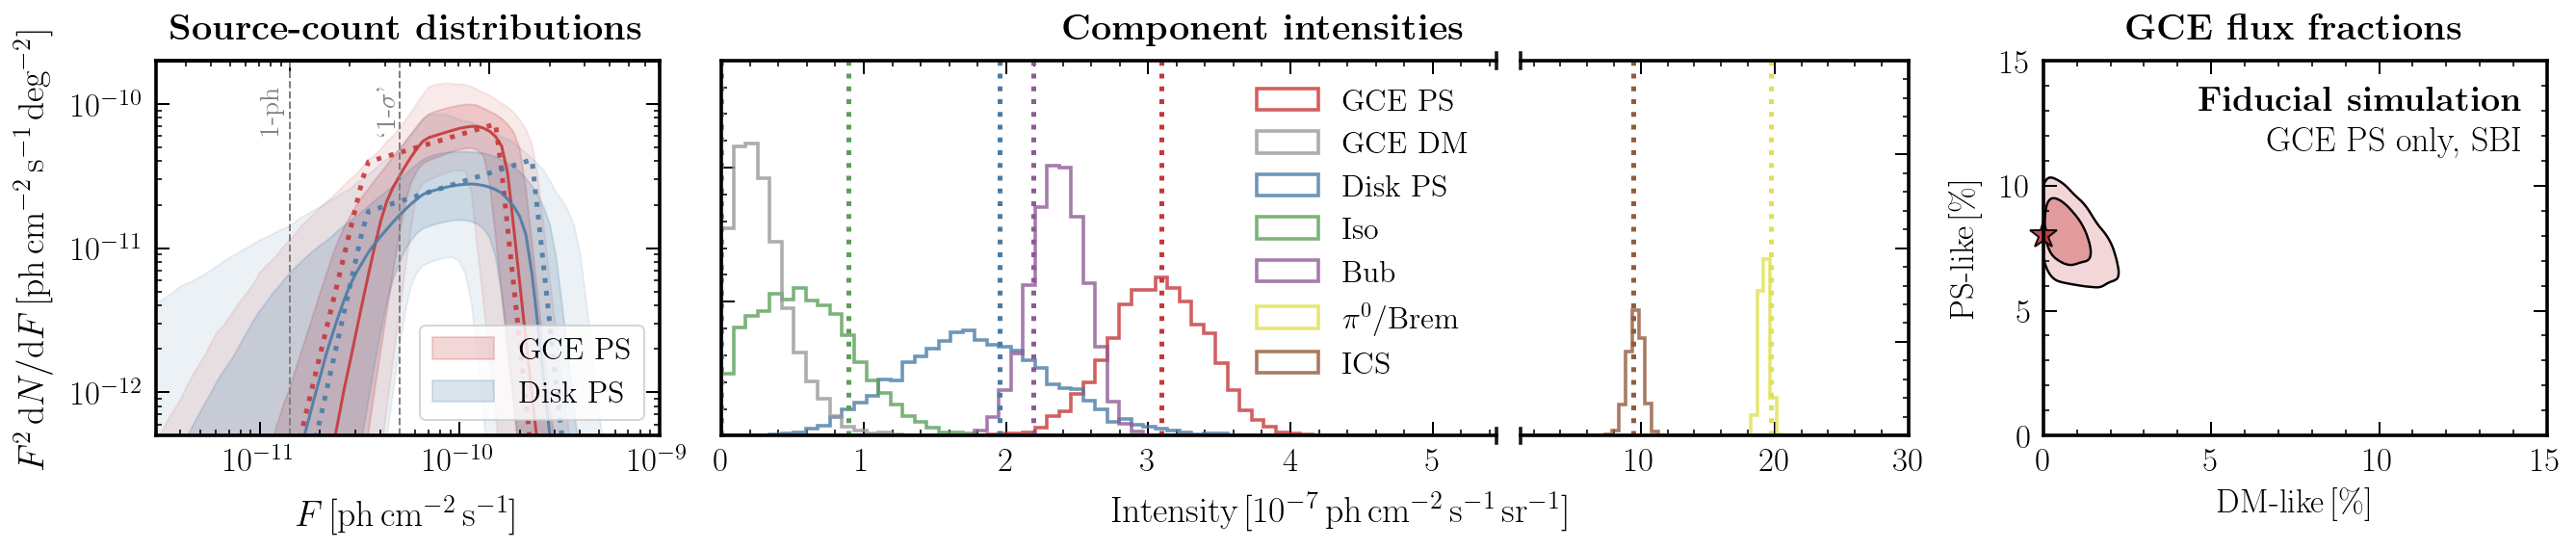

<Figure size 432x324 with 0 Axes>

In [107]:
data_map = ring2nest(np.load("../data/samples/x_ModelO_PS_only.npy")[:n_test, 0, :], roi_sim_ring)
aux = np.load("../data/samples/x_aux_ModelO_PS_only.npy")[:n_test]
thetas = np.load("../data/samples/theta_ModelO_PS_only.npy")[:n_test]

x_presimulated = torch.Tensor(data_map).unsqueeze(1)
x_aux_presimulated = torch.Tensor(aux)
theta_presimulated = (thetas)

inference_inst.x_shape = x_shape_from_simulation(x_presimulated)
posterior = inference_inst.build_posterior(prior, density_estimator)

x_test = torch.cat([x_presimulated, x_aux_presimulated], axis=-1)
theta_test = theta_presimulated

make_plot(posterior=posterior, x_test=x_test, theta_test=theta_test, roi_sim=roi_sim, roi_normalize=roi_normalize, 
          roi_counts_normalize=roi_mask_norm, figsize=(24 / 1.3, 5 / 1.3), n_samples=n_samples, temps_dict=temps_dict, 
          save_filename="../paper/plots/sim_sbi_ps_agg.pdf", sub1=r"\bf{Fiducial simulation}", sub2="GCE PS only, SBI", combined_posterior=True, thin_factor=1 / (n_test)) 

## Model A

In [108]:
temps_poiss_sim = hp.reorder(([temp_gce, temp_iso, temp_bub, temp_psc, temp_mA_pibrem, temp_mA_ics]), r2n=True)
temps_ps_sim = hp.reorder(([temp_gce / rescale, temp_dsk / rescale]), r2n=True)

temps_dict = {'fermi_exp':fermi_exp,
 'temps_ps':temps_ps,
 'temps_ps_sim':temps_ps_sim,
 'ps_labels':ps_labels,
 'temps_poiss':temps_poiss,
 'temps_poiss_sim':temps_poiss_sim,
 'poiss_labels':poiss_labels}

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

Removed no burn in
$9.0^{+0.3}_{-0.7}$ & $72.5^{+6.0}_{-13.6}$ & $2.5^{+0.2}_{-0.5}$ & $5.7^{+0.5}_{-1.2}$ & $2.6^{+0.3}_{-0.7}$


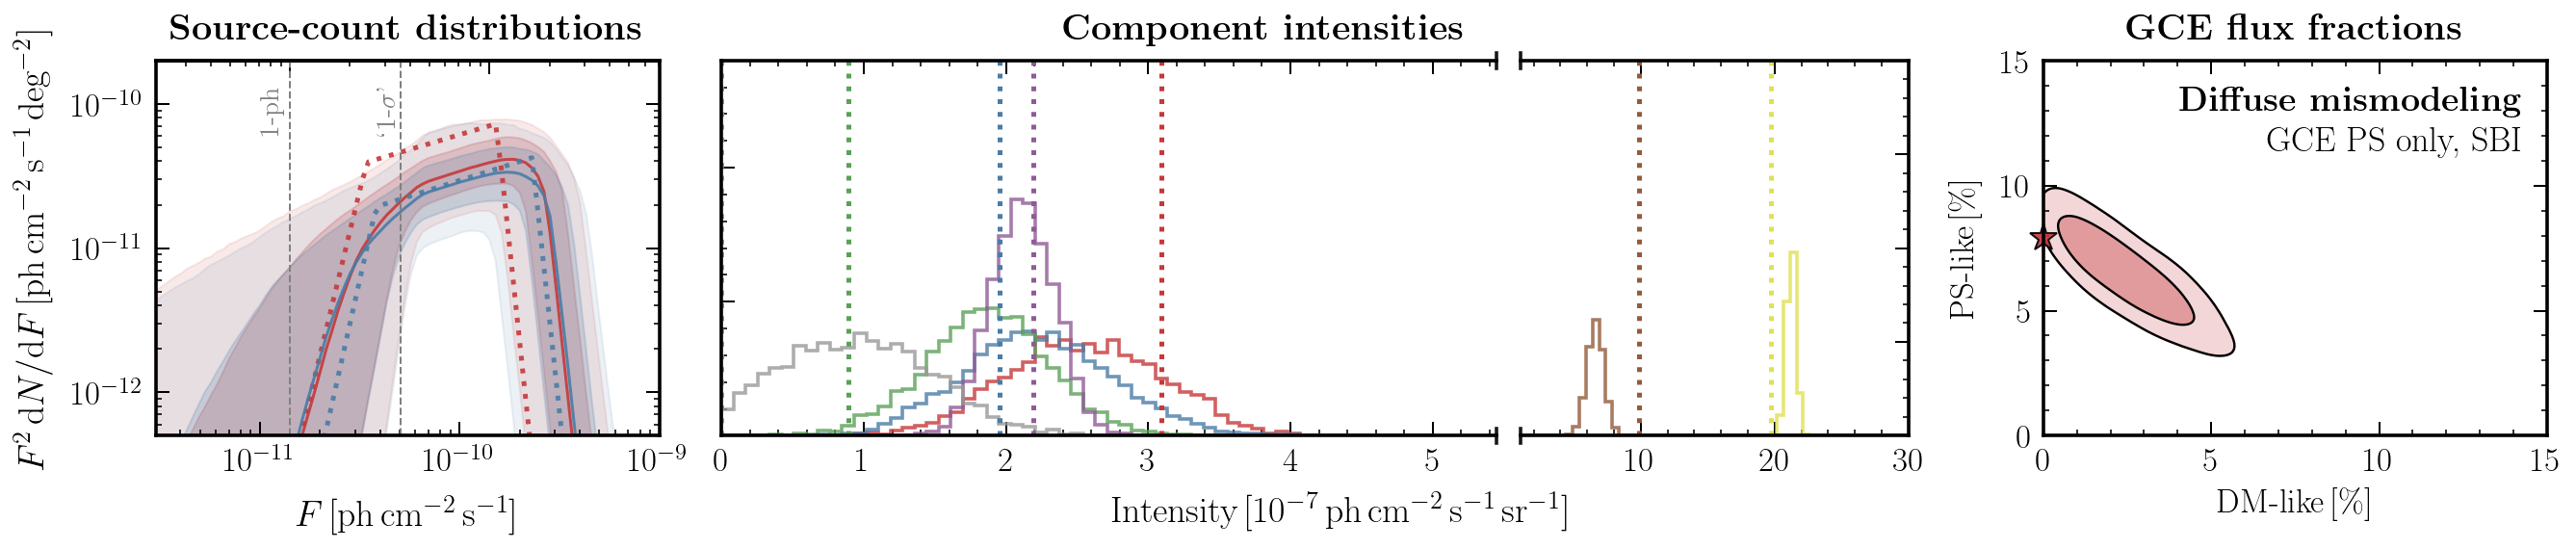

<Figure size 432x324 with 0 Axes>

In [109]:
data_map = ring2nest(np.load("../data/samples/x_ModelA_PS_only.npy")[:n_test, 0, :], roi_sim_ring)
aux = np.load("../data/samples/x_aux_ModelA_PS_only.npy")[:n_test]
thetas = np.load("../data/samples/theta_ModelA_PS_only.npy")[:n_test]

x_presimulated = torch.Tensor(data_map).unsqueeze(1)
x_aux_presimulated = torch.Tensor(aux)
theta_presimulated = (thetas)

inference_inst.x_shape = x_shape_from_simulation(x_presimulated)
posterior = inference_inst.build_posterior(prior, density_estimator)

x_test = torch.cat([x_presimulated, x_aux_presimulated], axis=-1)
theta_test = theta_presimulated

make_plot(posterior=posterior, x_test=x_test, theta_test=theta_test, roi_sim=roi_sim, roi_normalize=roi_normalize, roi_counts_normalize=roi_mask_norm,\
          figsize=(24 / 1.3, 5 / 1.3), n_samples=n_samples, temps_dict=temps_dict, 
          save_filename="../paper/plots/sim_sbi_modelA_ps.pdf", sub1=r"\bf{Diffuse mismodeling}", sub2="GCE PS only, SBI", 
          combined_posterior=True, thin_factor=1 / (n_test), show_legend=False) 

## Thick disk

In [110]:
temps_poiss_sim = hp.reorder(([temp_gce, temp_iso, temp_bub, temp_psc, temp_mO_pibrem, temp_mO_ics]), r2n=True)
temps_ps_sim = hp.reorder(([temp_gce / rescale, temp_dsk_thk / rescale]), r2n=True)

temps_dict = {'fermi_exp':fermi_exp,
 'temps_ps':temps_ps,
 'temps_ps_sim':temps_ps_sim,
 'ps_labels':ps_labels,
 'temps_poiss':temps_poiss,
 'temps_poiss_sim':temps_poiss_sim,
 'poiss_labels':poiss_labels}

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

Removed no burn in
$8.1^{+0.3}_{-0.7}$ & $89.2^{+2.7}_{-9.0}$ & $1.6^{+0.2}_{-0.4}$ & $5.1^{+0.5}_{-1.1}$ & $2.7^{+0.2}_{-0.6}$


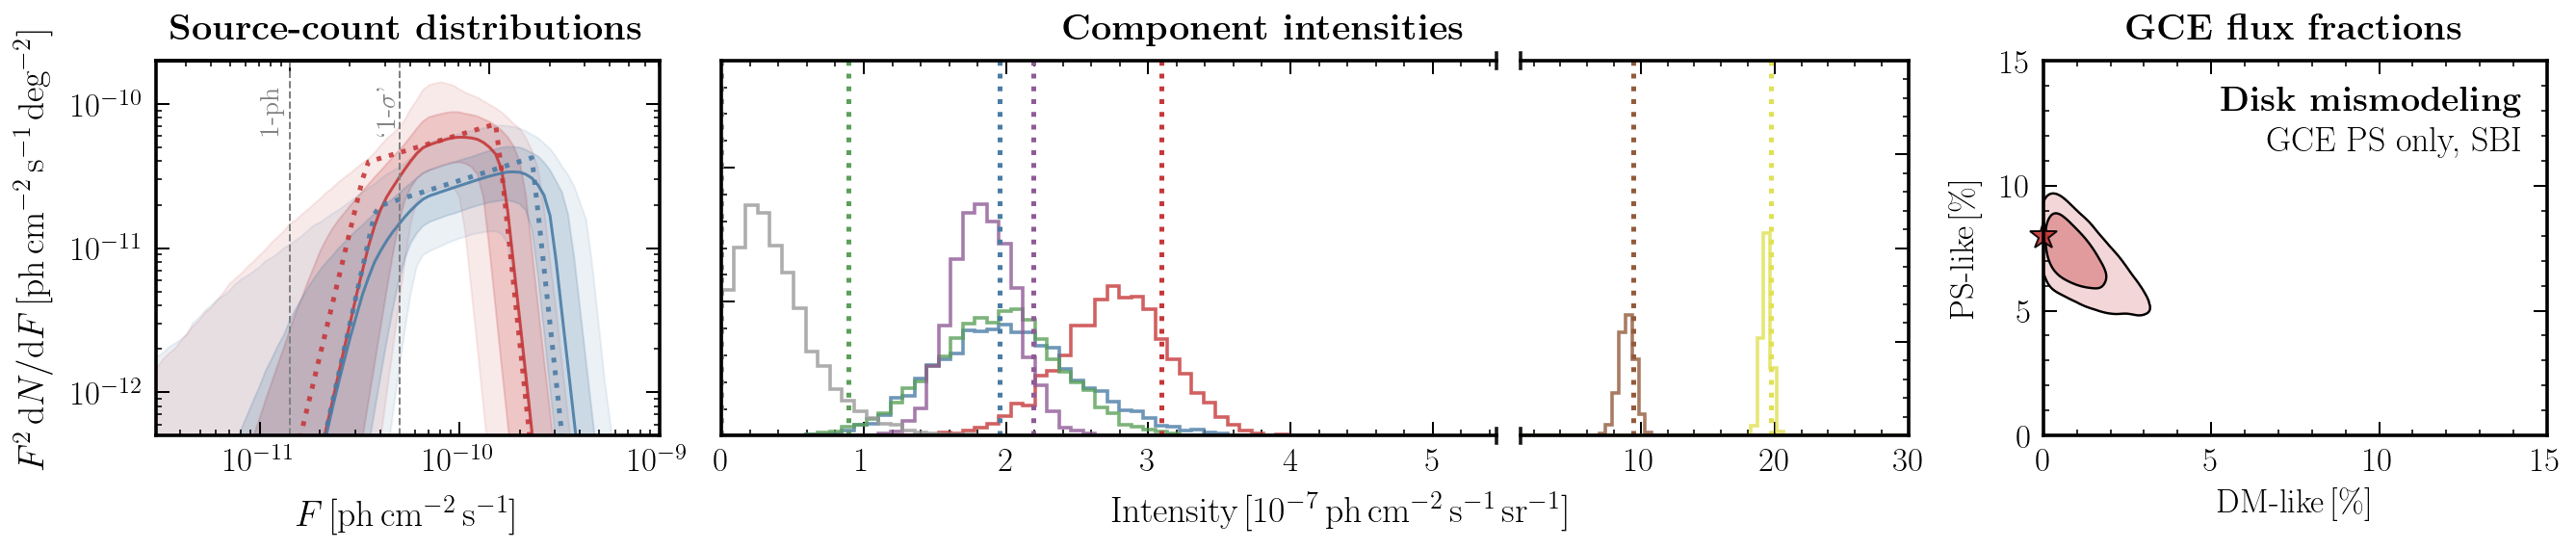

<Figure size 432x324 with 0 Axes>

In [111]:
data_map = ring2nest(np.load("../data/samples/x_ModelO_thick_disk_PS_only.npy")[:n_test, 0, :], roi_sim_ring)
aux = np.load("../data/samples/x_aux_ModelO_thick_disk_PS_only.npy")[:n_test]
thetas = np.load("../data/samples/theta_ModelO_thick_disk_PS_only.npy")[:n_test]

x_presimulated = torch.Tensor(data_map).unsqueeze(1)
x_aux_presimulated = torch.Tensor(aux)
theta_presimulated = (thetas)

inference_inst.x_shape = x_shape_from_simulation(x_presimulated)
posterior = inference_inst.build_posterior(prior, density_estimator)

x_test = torch.cat([x_presimulated, x_aux_presimulated], axis=-1)
theta_test = theta_presimulated

make_plot(posterior=posterior, x_test=x_test, theta_test=theta_test, roi_sim=roi_sim, roi_normalize=roi_normalize, roi_counts_normalize=roi_mask_norm, 
          figsize=(24 / 1.3, 5 / 1.3), n_samples=n_samples, temps_dict=temps_dict, save_filename="../paper/plots/sim_sbi_thick_disk_mm_ps.pdf", 
          sub1=r"\bf{Disk mismodeling}", sub2="GCE PS only, SBI", combined_posterior=True, thin_factor=1 / (n_test), show_legend=False) 